In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
BASE_DIR = '/content/drive/My Drive/projek-kb/age/UTKFace'

In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []


for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)


  0%|          | 0/23728 [00:00<?, ?it/s]

In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.head()

,image,age
0,/content/drive/My Drive/projek-kb/age/UTKFace/...,75
1,/content/drive/My Drive/projek-kb/age/UTKFace/...,9
2,/content/drive/My Drive/projek-kb/age/UTKFace/...,89
3,/content/drive/My Drive/projek-kb/age/UTKFace/...,86
4,/content/drive/My Drive/projek-kb/age/UTKFace/...,89


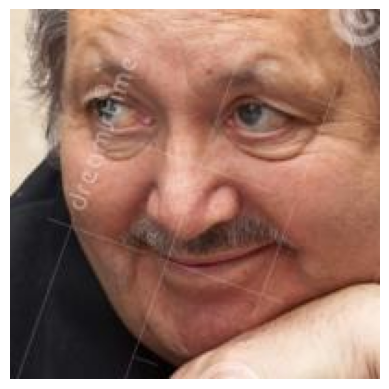

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

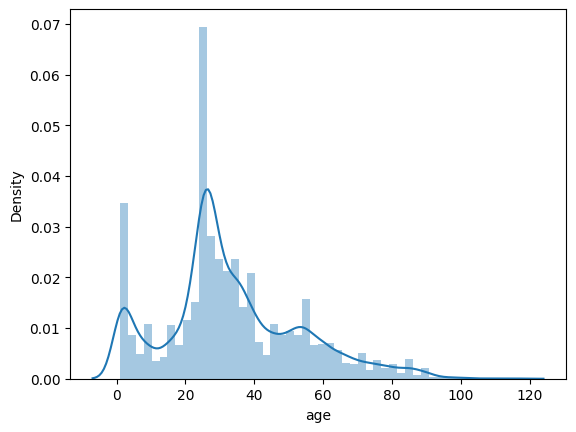

In [ ]:
sns.distplot(df['age'])

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23728 [00:00<?, ?it/s]

In [ ]:
path = "/content/drive/My Drive/projek-kb/age/fileX"
import pickle as pickle

In [ ]:

# with open(path, "wb") as f:
#   pickle.dump(X, f)

In [ ]:
with open(path, "rb") as f:
  X = pickle.load(f)
  print(len(X))

23728


In [ ]:
X.shape

(23728, 128, 128, 1)

In [ ]:
# normalize the images
X = X/255.0

In [ ]:

y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

In [ ]:
inputs = Input(shape=input_shape)

# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_2 = Dense(256, activation='relu')(flatten)
dropout_2 = Dropout(0.4)(dense_2)

# Output layer
output_2 = Dense(1, activation='linear', name='age_out')(dropout_2)

# Define the model
model = Model(inputs=[inputs], outputs=[output_2])


# Compile the model with custom accuracy metric

model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Plot the model


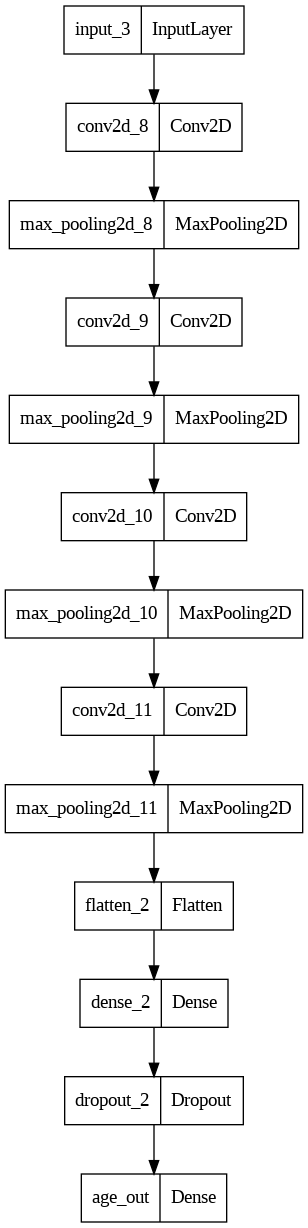

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/projek-kb/age/cnn_logs/age_model_checkpoint.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [ ]:
tensorboard = TensorBoard(log_dir='/content/drive/My Drive/projek-kb/age/cnn_logs', histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
history = model.fit(
    x=X,
    y= y_age,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[checkpoint, tensorboard]
)

Epoch 1/30
594/594 [==============================] - ETA: 0s - loss: 14.2325 - mae: 14.2325
Epoch 1: val_loss improved from inf to 9.63372, saving model to /content/drive/My Drive/projek-kb/age/cnn_logs/age_model_checkpoint.h5
594/594 [==============================] - 19s 29ms/step - loss: 14.2325 - mae: 14.2325 - val_loss: 9.6337 - val_mae: 9.6337
Epoch 2/30
592/594 [============================>.] - ETA: 0s - loss: 11.5085 - mae: 11.5085
Epoch 2: val_loss improved from 9.63372 to 7.84114, saving model to /content/drive/My Drive/projek-kb/age/cnn_logs/age_model_checkpoint.h5
594/594 [==============================] - 13s 22ms/step - loss: 11.5090 - mae: 11.5090 - val_loss: 7.8411 - val_mae: 7.8411
Epoch 3/30
591/594 [============================>.] - ETA: 0s - loss: 9.7759 - mae: 9.7759
Epoch 3: val_loss did not improve from 7.84114
594/594 [==============================] - 12s 21ms/step - loss: 9.7732 - mae: 9.7732 - val_loss: 9.7092 - val_mae: 9.7092
Epoch 4/30
594/594 [=========

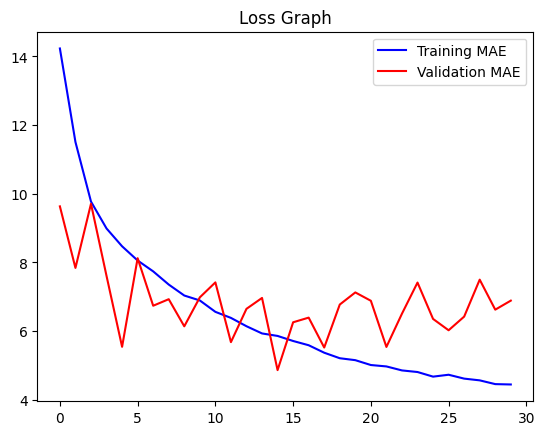

In [ ]:
# plot results for age
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
import h5py

# Save the entire model
model.save("/content/drive/My Drive/projek-kb/age/age_model_acc.h5")

# # Save history dictionary to a file in HDF5 format
# history_path = "/content/drive/My Drive/projek-kb/age/age_model_history.h5"
# with h5py.File(history_path, 'w') as hf:
#     for key, value in history.history.items():
#         hf.create_dataset(key, data=value)



Original Age: 86
1/1 [==============================] - 0s 17ms/step
Predicted Age: 87


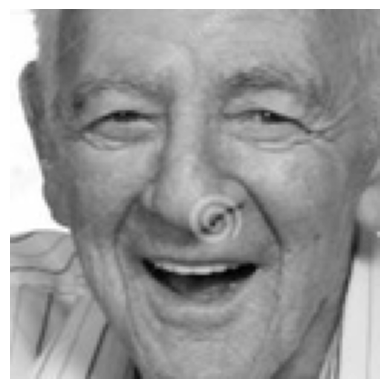

In [ ]:
image_index = 100
print("Original Age:", y_age[image_index])
# predict from model
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

pred_age = round(pred[0][0])  # Accessing the age prediction
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');